In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [2]:
# TODO: split X_train into train and dev sets
# TODO: convert outputs to log outputs first


In [3]:
# TODO: replace evaluation metrics with the below 

def rmsle_eval(preds, dtrain):
    """
    Custom evaluation metric: Root Mean Squared Log Error (RMSLE)
    preds: predicted values (raw predictions)
    dtrain: either a DMatrix with a get_label() method or a numpy array of true labels.
    Returns: tuple (metric name, RMSLE value as a float)
    """
    if hasattr(dtrain, 'get_label'):
        labels = dtrain.get_label()
    else:
        labels = dtrain
    # Avoid issues with log(0)
    preds = np.maximum(preds, 1e-6)
    labels = np.maximum(labels, 1e-6)
    rmsle = np.sqrt(np.mean((np.log1p(preds) - np.log1p(labels)) ** 2))
    return 'rmsle', float(rmsle)


In [4]:
train = pd.read_csv('./data/train_transformed.csv')
X_test = pd.read_csv('./data/test_transformed.csv')

X_train = train.drop('SalePrice',axis=1)
y_train = train.SalePrice

#X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# adding missing 1-hot encoded columns so regression has same columns
for col in X_train.columns:
    if col not in X_test.columns:
        X_test[col] = False

# TODO fix.. just dropping this extra 1-hot encoded column that appeared in the test set
X_test.drop('MSSubClass_150',axis=1,inplace=True)

X_test = X_test[X_train.columns]

In [5]:
# for xgboost

train_xgb = pd.read_csv('./data/train_transformed_xgb.csv')
X_test_xgb = pd.read_csv('./data/test_transformed_xgb.csv')

X_train_xgb = train.drop('SalePrice',axis=1)
y_train_xgb = train.SalePrice

#X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# adding missing 1-hot encoded columns so regression has same columns
for col in X_train_xgb.columns:
    if col not in X_test_xgb.columns:
        X_test_xgb[col] = False

# TODO fix.. just dropping this extra 1-hot encoded column that appeared in the test set
X_test_xgb.drop('MSSubClass_150',axis=1,inplace=True)

X_test_xgb = X_test_xgb[X_train_xgb.columns]

# Linear Regression

In [6]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_train)

# one house has a negative sales price prediction... need to fix this too
pred_adj = [x if x > 0 else 1 for x in pred]

log_true = np.log(y_train)
log_pred = np.log(pred_adj)

np.round(root_mean_squared_error(log_true,log_pred),4)

0.3131

In [7]:
lr_submission = pd.DataFrame()
lr_submission['Id'] = X_test['Id']
lr_submission['SalePrice'] = np.round(lr.predict(X_test),4)

#lr_submission.to_csv('linear-regression.csv',index=False)

# XGBoost


XGBoost (eXtreme Gradient Boosting) is a highly efficient, scalable implementation of the gradient boosting framework. It builds an ensemble of decision trees in a sequential manner, where each new tree aims to correct the errors of the previous ensemble.

## What is XGBoost?

XGBoost is an optimized gradient boosting library designed to be highly efficient, flexible, and portable. It optimizes a regularized objective function to prevent overfitting. The overall objective function is given by:

$$
\mathcal{L} = \sum_{i=1}^{n} \ell(y_i, \hat{y}_i) + \sum_{k=1}^{K} \Omega(f_k)
$$

where:
- \( \ell(y_i, \hat{y}_i) \) is the loss function (e.g., mean squared error for regression),
- \( \Omega(f_k) \) is a regularization term for the \( k \)-th tree to control its complexity,
- \( n \) is the number of samples,
- \( K \) is the number of trees.

The regularization term typically includes both L1 and L2 components, which helps in reducing overfitting.

## Why is XGBoost Effective for Regression on Tabular Data?

1. **Regularization and Robustness:**  
   XGBoost incorporates both L1 and L2 regularization, which helps manage overfitting—a common issue in tabular datasets with noisy features.

2. **Handling Missing Values:**  
   The algorithm can automatically learn the best way to handle missing data, which is often encountered in real-world tabular datasets.

3. **Gradient Boosting Mechanism:**  
   By iteratively fitting new models to the residual errors of previous models, XGBoost effectively minimizes the loss. At each iteration \( t \), the model minimizes an approximated objective:

   $$
   \mathcal{L}^{(t)} \approx \sum_{i=1}^{n} \left[ g_i f_t(x_i) + \frac{1}{2} h_i f_t(x_i)^2 \right] + \Omega(f_t)
   $$

   where:
   $$  g_i = \frac{\partial \ell(y_i, \hat{y}_i^{(t-1)})}{\partial \hat{y}_i^{(t-1)}}  $$ is the gradient,
   $$  h_i = \frac{\partial^2 \ell(y_i, \hat{y}_i^{(t-1)})}{\partial \hat{y}_i^{(t-1)2}}  $$ is the Hessian (second derivative).

4. **Efficient Computation:**  
   XGBoost is designed for parallel processing, which speeds up the training process, especially on large tabular datasets.

5. **Capturing Feature Interactions:**  
   The tree-based model naturally captures non-linear relationships and interactions between features, making it very effective when these interactions are important for predicting the target variable.

6. **Customizable Loss Functions:**  
   Users can tailor the loss function to better suit the specific needs of the regression task, enhancing model performance.

In summary, XGBoost's robust regularization, efficient handling of missing data, gradient boosting mechanism, and ability to model complex interactions make it particularly effective for regression tasks on tabular data.


In [8]:
import xgboost as xgb

xgboost = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

xgboost.fit(X_train_xgb, y_train_xgb)

log_pred = np.log(xgboost.predict(X_train_xgb))
print('train:',np.round(root_mean_squared_error(log_true,log_pred),4))

xgb_submission = pd.DataFrame()
xgb_submission['Id'] = X_test['Id']
xgb_submission['SalePrice'] = np.round(xgboost.predict(X_test_xgb),4)

#xgb_submission.to_csv('xgboost.csv',index=False)

train: 0.0114


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# -----------------------------
# Define a custom evaluation metric for RMSLE
# -----------------------------
def rmsle_eval(preds, dtrain):
    """
    Custom evaluation metric: Root Mean Squared Log Error (RMSLE)
    preds: predicted values (raw predictions)
    dtrain: either a DMatrix with a get_label() method or a numpy array of true labels.
    Returns: tuple (metric name, RMSLE value as a float)
    """
    if hasattr(dtrain, 'get_label'):
        labels = dtrain.get_label()
    else:
        labels = dtrain
    # Avoid log(0)
    preds = np.maximum(preds, 1e-6)
    labels = np.maximum(labels, 1e-6)
    rmsle = np.sqrt(np.mean((np.log1p(preds) - np.log1p(labels)) ** 2))
    return 'rmsle', float(rmsle)

# Define a wrapper that returns only the metric value.
def custom_rmsle(preds, dtrain):
    return rmsle_eval(preds, dtrain)[1]
# Set the name attribute so that XGBoost uses it as the key in the evaluation log.
custom_rmsle.__name__ = "rmsle"

# -----------------------------
# 1. Hyperparameter Tuning with a Reduced Grid
# -----------------------------
# Initialize the XGBoost regressor (without early_stopping_rounds or eval_metric)
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

# Define a reduced hyperparameter grid for faster tuning
param_grid = {
    'max_depth': [2, 3, 5],          
    'learning_rate': [0.01, 0.05, 0.1], 
    'n_estimators': [500, 1000], 
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
}

from sklearn.metrics import make_scorer
rmsle_scorer = make_scorer(custom_rmsle)

grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error', 
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1
)

# Assume X_train and y_train are already defined
grid_search.fit(X_train_xgb, y_train_xgb)
print("Best parameters found:", grid_search.best_params_)

# Retrieve the best estimator from grid search
best_model = grid_search.best_estimator_

# -----------------------------
# 2. Training with Early Stopping and RMSLE Evaluation
# -----------------------------
# Further split X_train and y_train for early stopping
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_xgb, y_train_xgb, test_size=0.1, random_state=42
)

# Set early_stopping_rounds and custom eval_metric via set_params.
best_model.set_params(early_stopping_rounds=50, eval_metric=custom_rmsle)

# To track both training and validation errors, include the training subset in eval_set.
best_model.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_train_sub, y_train_sub), (X_val, y_val)],
    verbose=100
)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 1000, 'subsample': 0.9}
[0]	validation_0-rmse:75096.35078	validation_0-rmsle:0.39052	validation_1-rmse:93123.47131	validation_1-rmsle:0.43938
[100]	validation_0-rmse:24526.01027	validation_0-rmsle:0.14167	validation_1-rmse:34352.74099	validation_1-rmsle:0.15808
[200]	validation_0-rmse:19685.52305	validation_0-rmsle:0.11572	validation_1-rmse:29730.17050	validation_1-rmsle:0.12767
[300]	validation_0-rmse:17535.88217	validation_0-rmsle:0.10459	validation_1-rmse:28854.74040	validation_1-rmsle:0.11940
[400]	validation_0-rmse:16213.69828	validation_0-rmsle:0.09783	validation_1-rmse:28756.82911	validation_1-rmsle:0.11742
[429]	validation_0-rmse:15865.57939	validation_0-rmsle:0.09621	validation_1-rmse:28825.95845	validation_1-rmsle:0.11698


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False,
             eval_metric=<function custom_rmsle at 0x161d0dee0>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

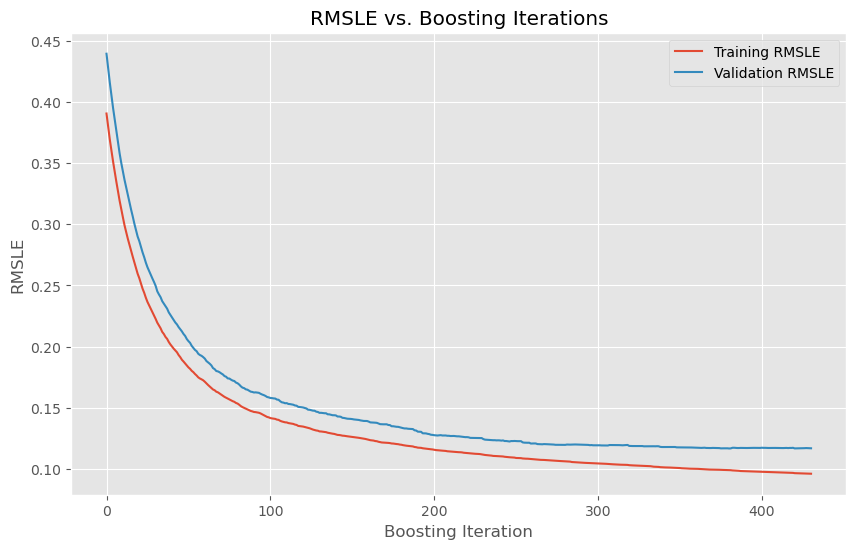

In [10]:

# -----------------------------
# 3. Retrieve Evaluation Results and Plot
# -----------------------------
evals_result = best_model.evals_result()
# The evaluation results should now use 'rmsle' as key.
# Typically, evals_result has two keys: one for the training set ('validation_0') 
# and one for the validation set ('validation_1').
train_rmsle = evals_result['validation_0']['rmsle']
val_rmsle   = evals_result['validation_1']['rmsle']

iterations = np.arange(len(train_rmsle))

plt.figure(figsize=(10, 6))
plt.plot(iterations, train_rmsle, label='Training RMSLE')
plt.plot(iterations, val_rmsle, label='Validation RMSLE')
plt.xlabel('Boosting Iteration')
plt.ylabel('RMSLE')
plt.title('RMSLE vs. Boosting Iterations')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 4. (Optional) Evaluation on a Test Set
# -----------------------------
# If you have a separate test set defined as X_test and y_test:
# predictions = best_model.predict(X_test)
# mse = mean_squared_error(y_test, predictions)
# print("Test MSE:", mse)

In [11]:
dev_error = pd.DataFrame()

dev_error['y'] = y_val
dev_error['y_pred'] = best_model.predict(X_val)
#dev_error.to_csv('xgb-validation-error.csv',index=False)

# For submission

In [12]:
submission_xgb = pd.DataFrame()
submission_xgb['Id'] = X_test_xgb['Id']
submission_xgb['SalePrice'] = best_model.predict(X_test_xgb)  # re-exponentiate

submission_xgb.to_csv('xgb-optimized.csv',index=False)

# Neural Network (Feed Forward)


0.11504029543840721


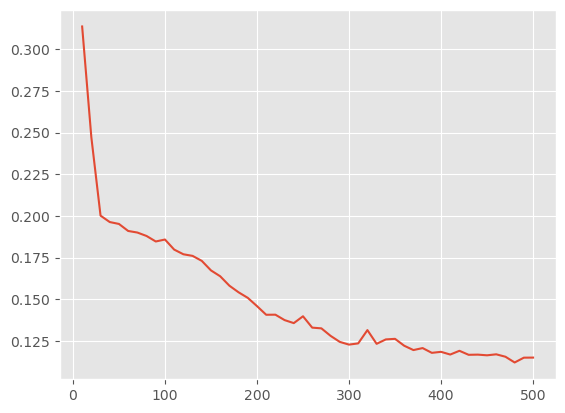

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import random

# Set the seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Ensure deterministic behavior on GPU (might impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Convert your pandas DataFrames to numeric NumPy arrays and then to tensors.
X_train_numeric = X_train.astype(np.float32)
y_train_numeric = y_train.astype(np.float32)
X_test_numeric  = X_test.astype(np.float32)

X_train_tensor = torch.tensor(X_train_numeric.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_numeric.to_numpy(), dtype=torch.float32).unsqueeze(1)
X_test_tensor  = torch.tensor(X_test_numeric.to_numpy(), dtype=torch.float32)

# Create a DataLoader for mini-batch training.
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define a simple feed-forward neural network.
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim):
        super(FeedForwardNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Output layer for regression
        )
    
    def forward(self, x):
        return self.net(x)

# Instantiate the model.
input_dim = X_train_tensor.shape[1]
model = FeedForwardNN(input_dim)

# Define the custom loss function: RMSE of log values.
def rmse_log_loss(pred, target, epsilon=1e-7):
    # Clamp predictions and targets to ensure positivity
    pred = torch.clamp(pred, min=epsilon)
    target = torch.clamp(target, min=epsilon)
    return torch.sqrt(torch.mean((torch.log(pred) - torch.log(target)) ** 2))

# Define the optimizer.
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = []
losses = []

# Training loop.
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()                # Clear gradients
        outputs = model(batch_X)               # Forward pass
        loss = rmse_log_loss(outputs, batch_y) # Compute custom loss
        loss.backward()                        # Backpropagation
        optimizer.step()                       # Update weights
        
        epoch_loss += loss.item() * batch_X.size(0)
    
    epoch_loss /= len(train_loader.dataset)
    if (epoch + 1) % 10 == 0:
        #print(f"Epoch [{epoch+1}/{num_epochs}], RMSE Log Loss: {epoch_loss:.4f}")

        epochs.append(epoch+1)
        losses.append(epoch_loss)

'''
# Predict on the test set.
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    print("First five predictions:")
    print(predictions[:5])
'''
print()

plt.plot(epochs,losses)

print(losses[-1])

In [11]:
# Set the model to evaluation mode
model.eval()

# Predict on the test set without tracking gradients
with torch.no_grad():
    predictions = model(X_test_tensor)
    print("Predictions on X_test:")
    print(predictions)

nn_submission = pd.DataFrame()
nn_submission['Id'] = X_test['Id']
nn_submission['SalePrice'] = predictions

#nn_submission.to_csv('feedforwardnn.csv',index=False)

Predictions on X_test:
tensor([[127700.7734],
        [171852.7656],
        [197446.3281],
        ...,
        [162636.6250],
        [135448.1094],
        [229203.6719]])
